<a href="https://colab.research.google.com/github/harshavardhangadila/Basic-Neural-Network-Using-Numpy-Keras-Pytorch-and-Jax/blob/main/9)_TensorFlow_Low_Level_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Step 2: Different 3-variable nonlinear function
def generate_data(n_samples=1000):
    x1 = np.random.uniform(-3, 3, n_samples)
    x2 = np.random.uniform(-3, 3, n_samples)
    x3 = np.random.uniform(-3, 3, n_samples)
    # Different nonlinear equation: smooth + nonlinearity + interaction
    y = np.exp(np.sin(x1)) + np.log1p(x2**2) + x3 * np.cos(x1 * x2)
    y += np.random.normal(0, 0.1, n_samples)  # Add some noise
    X = np.column_stack([x1, x2, x3]).astype(np.float32)
    y = y.reshape(-1, 1).astype(np.float32)
    return tf.constant(X), tf.constant(y)

X, y = generate_data()

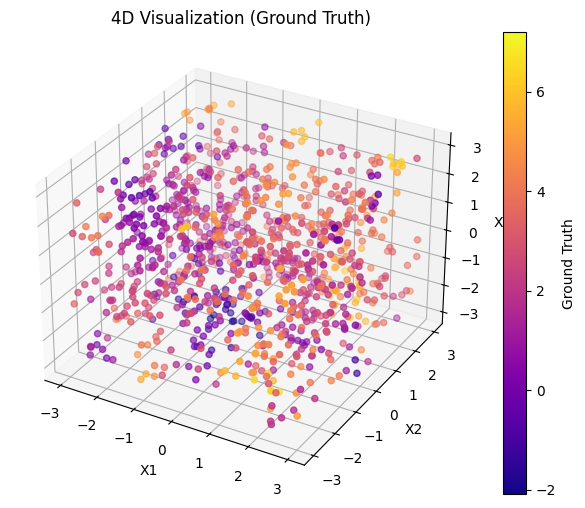

In [3]:
# Step 3: 4D Visualization of Target
def plot_4d(X_np, y_np, label='Target'):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], c=y_np[:, 0], cmap='plasma')
    plt.colorbar(sc, label=label)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    ax.set_title(f"4D Visualization ({label})")
    plt.show()

plot_4d(X.numpy(), y.numpy(), label="Ground Truth")

In [4]:
# Step 4: Initialize Parameters (He Init)
def he_init(shape):
    return tf.Variable(tf.random.normal(shape) * tf.sqrt(2.0 / shape[0]))

input_dim = 3
hidden1 = 64
hidden2 = 32
output_dim = 1

W1 = he_init((input_dim, hidden1))
b1 = tf.Variable(tf.zeros((hidden1,)))
W2 = he_init((hidden1, hidden2))
b2 = tf.Variable(tf.zeros((hidden2,)))
W3 = he_init((hidden2, output_dim))
b3 = tf.Variable(tf.zeros((output_dim,)))

In [5]:
# Step 5: ReLU and Forward Pass using tf.einsum
def relu(x):
    return tf.maximum(x, 0.0)

def forward_pass(X):
    z1 = tf.einsum('ij,jk->ik', X, W1) + b1
    a1 = relu(z1)
    z2 = tf.einsum('ij,jk->ik', a1, W2) + b2
    a2 = relu(z2)
    z3 = tf.einsum('ij,jk->ik', a2, W3) + b3
    return z3

In [6]:
# Step 6: Training Loop
lr = 0.001
epochs = 1000
loss_history = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = forward_pass(X)
        loss = tf.reduce_mean((y - y_pred)**2)

    gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
    for var, grad in zip([W1, b1, W2, b2, W3, b3], gradients):
        var.assign_sub(lr * grad)

    loss_history.append(loss.numpy())
    if epoch % 100 == 0 or epoch < 5:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")


Epoch 0, Loss: 5.2379
Epoch 1, Loss: 4.7488
Epoch 2, Loss: 4.3674
Epoch 3, Loss: 4.0696
Epoch 4, Loss: 3.8351
Epoch 100, Loss: 1.9767
Epoch 200, Loss: 1.7722
Epoch 300, Loss: 1.6496
Epoch 400, Loss: 1.5714
Epoch 500, Loss: 1.5229
Epoch 600, Loss: 1.4862
Epoch 700, Loss: 1.4573
Epoch 800, Loss: 1.4321
Epoch 900, Loss: 1.4071


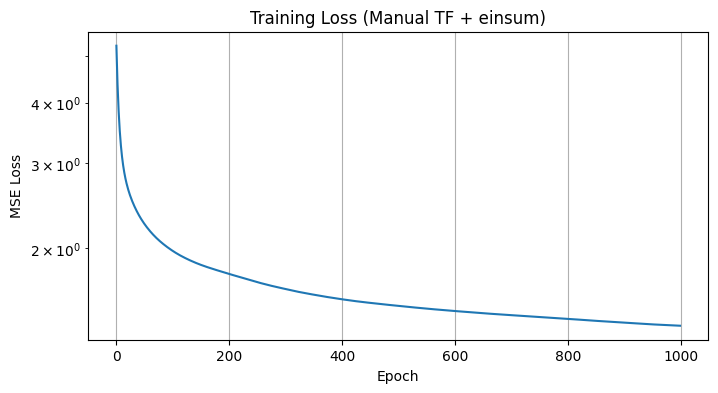

In [7]:
# Step 7: Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Training Loss (Manual TF + einsum)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.grid(True)
plt.show()


In [8]:
# Step 8: Prediction and Evaluation
y_pred = forward_pass(X)

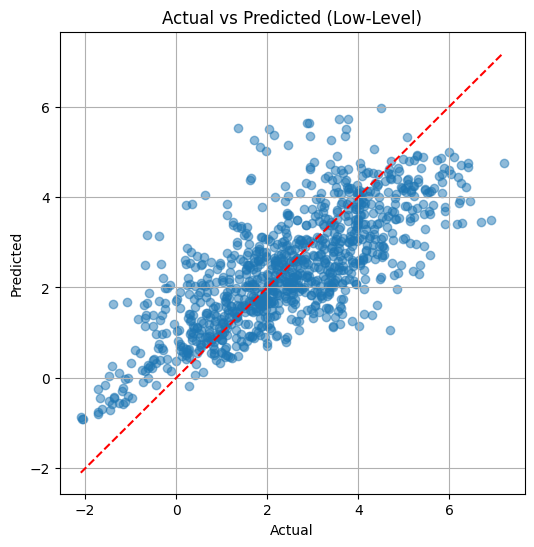

In [9]:
# Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y.numpy(), y_pred.numpy(), alpha=0.5)
plt.plot([y.numpy().min(), y.numpy().max()], [y.numpy().min(), y.numpy().max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Low-Level)")
plt.grid(True)
plt.show()

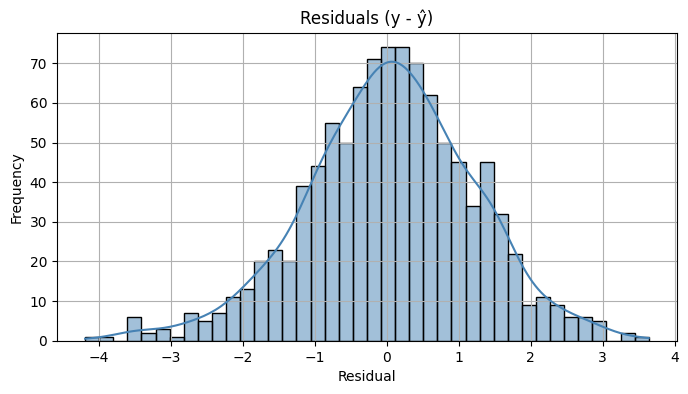

In [10]:
# Residual Plot
residuals = (y - y_pred).numpy().flatten()
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=40, kde=True, color='steelblue')
plt.title("Residuals (y - ŷ)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

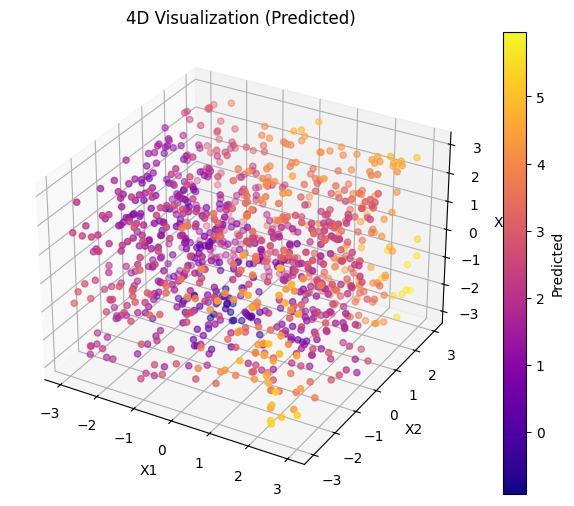

In [11]:
# 4D Prediction Plot
plot_4d(X.numpy(), y_pred.numpy(), label="Predicted")

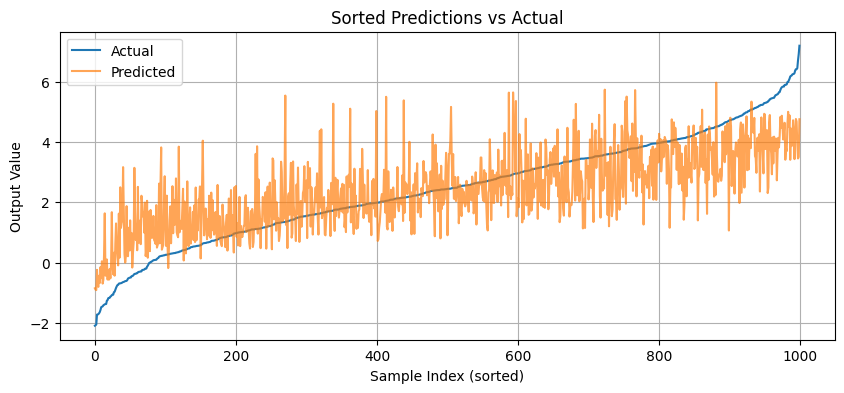

In [12]:
# Sorted Predictions vs Ground Truth
sorted_idx = tf.argsort(y[:, 0])
plt.figure(figsize=(10, 4))
plt.plot(tf.gather(y, sorted_idx), label="Actual")
plt.plot(tf.gather(y_pred, sorted_idx), label="Predicted", alpha=0.7)
plt.title("Sorted Predictions vs Actual")
plt.xlabel("Sample Index (sorted)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Step 9: Custom Predictions
def predict_custom(x1, x2, x3):
    sample = tf.constant([[x1, x2, x3]], dtype=tf.float32)
    return forward_pass(sample).numpy()[0][0]

test_pts = [(-2, -2, -2), (0, 0, 0), (2, 2, 2)]
print("\nCustom Test Predictions:")
for x1, x2, x3 in test_pts:
    pred = predict_custom(x1, x2, x3)
    actual = np.exp(np.sin(x1)) + np.log1p(x2**2) + x3 * np.cos(x1 * x2)
    print(f"Input: ({x1}, {x2}, {x3}) → Prediction: {pred:.3f}, Actual: {actual:.3f}")


Custom Test Predictions:
Input: (-2, -2, -2) → Prediction: 1.546, Actual: 3.320
Input: (0, 0, 0) → Prediction: 0.272, Actual: 1.000
Input: (2, 2, 2) → Prediction: 3.749, Actual: 2.785
